# VQA using InceptionResNet, bidirectional LSTM's blocks and <br> GloVe embedding

In [ ]:
# option to view all the outputs of a cell and not just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# import the required libraries
import os
import tensorflow as tf
import numpy as np
import pandas as pd

import PIL.Image

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Get current working directory
cwd = os.getcwd()

In [ ]:
# the original file was implemented in Google Colab to take advantage of the free GPU 
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Data preprocessing

In [ ]:
# load the questions
dataset_dir = '/content/drive/My Drive/NeuralNetworks/VQA_Dataset'
annotations_dir = os.path.join(dataset_dir, 'train_questions_annotations.json')
annotations = pd.read_json(annotations_dir).transpose()
annotations.reset_index(inplace=True, drop=True)
annotations.head()
annotations.describe()
N = len(annotations)

,question,image_id,answer
0,Who looks happier?,11779,man
1,Where is the woman sitting?,11779,blanket
2,Where is the man sitting?,11779,bench
3,Is this man hungry?,5536,yes
4,Who is holding the football?,16949,man


,question,image_id,answer
count,58832,58832,58832
unique,34035,28744,58
top,What color is the rug?,24606,yes
freq,387,3,18386


All answers consist of a single word. Therefore, I can approach the problem as a classification task, where the target labels are the answers to the various questions. I use one-hot encoding to encode the classes. 

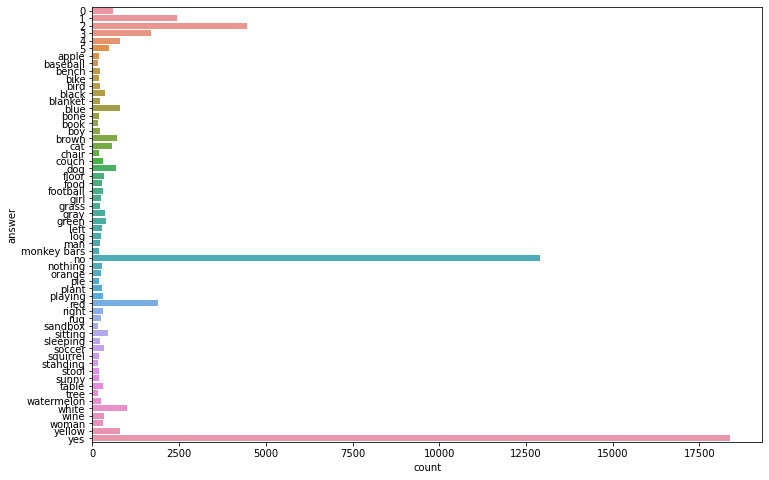

In [ ]:
# Classes' histograms  
annotations["answer"] = annotations["answer"].astype('category')
num_classes = annotations["answer"].value_counts().count()

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(y="answer", data=annotations)

As expected, some classes are way more represented than others (e.g. "yes" or "no"). <br>For this reason I will use a stratified sampling for the training/validation set division.

In [ ]:
# Perform the one-hot encoding and add it to the dataset
annotations['class_encoded'] = annotations["answer"].cat.codes
one_hot =  tf.keras.utils.to_categorical(annotations['class_encoded'])
annotations["one_hot"] = 0
annotations["one_hot"] = annotations["one_hot"].astype(object)

for i in range(N):
    annotations.at[i, "one_hot"] = one_hot[i]
annotations.head()

### GloVe Embedding

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_qs_length = 21 

vectorizer = TextVectorization(max_tokens=10000, output_sequence_length=max_qs_length) 
vectorizer.adapt(annotations['question'].tolist())

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
# load the GloVe embedding
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-01-22 10:55:37--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-01-22 10:55:37--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-01-22 10:55:37--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
embeddings_index = {}
with open('glove.6B.100d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
num_tokens = len(voc) + 2
embedding_dim = 32 
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 4528 words (65 misses)


In [ ]:
# Embedding layer to be added to the model
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [ ]:
# Add the embedded questions to the dataset
annotations["qs_tokenized"] = 0
annotations["qs_tokenized"] = annotations["qs_tokenized"].astype(object)

for i in range(N):
    annotations.at[i, "qs_tokenized"] = vectorizer([annotations.at[i, "question"]]).numpy()[0]
annotations.head()

,question,image_id,answer,class_encoded,one_hot,qs_tokenized
0,Who looks happier?,11779,man,31,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[48, 804, 2059, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Where is the woman sitting?,11779,blanket,12,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[25, 3, 2, 16, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Where is the man sitting?,11779,bench,8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[25, 3, 2, 15, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Is this man hungry?,5536,yes,57,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3, 22, 15, 487, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,Who is holding the football?,16949,man,31,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[48, 3, 50, 2, 235, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


### Training/Validation splitting

In [ ]:
df = annotations.drop(['question', 'answer', 'class_encoded'], axis=1)
df.head()

,image_id,one_hot,qs_tokenized
0,11779,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[48, 804, 2059, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,11779,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[25, 3, 2, 16, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,11779,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[25, 3, 2, 15, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,5536,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3, 22, 15, 487, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,16949,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[48, 3, 50, 2, 235, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [ ]:
# Stratified sampling
from sklearn.model_selection import train_test_split

y = annotations['class_encoded']
df_train, df_valid = train_test_split(df, test_size=0.25, random_state=SEED, stratify=y)

### Costum Dataset creation to manage the images and questions flow during the training

In [ ]:
# it is necessary to modify the class "CustomDataset" in order to create a flow of pairs of images and questions
# for the training (this function is not currently implemented in keras)

from PIL import Image

img_h = 299
img_w = 299
# Height and width of the original Inception ResNet architecture

class CustomDataset(tf.keras.utils.Sequence):

    """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

    """

    def __init__(self, dataset, dataset_dir, preprocessing_function=None, out_shape=[img_h, img_w]):
        subset_filenames = dataset['image_id'].tolist()
        subset_tokenizedquestions = dataset['qs_tokenized'].tolist()
        subset_classes = dataset['one_hot'].tolist()

        self.dataset_dir = dataset_dir
        self.subset_filenames = subset_filenames
        self.subset_tokenizedquestions = subset_tokenizedquestions
        self.subset_classes = subset_classes
        self.preprocessing_function = preprocessing_function
        self.out_shape = out_shape

    def __len__(self):
        return len(self.subset_filenames)

    def __getitem__(self, index):
        # Read Image
        curr_filename = self.subset_filenames[index]
        curr_question = self.subset_tokenizedquestions[index]
        curr_class = self.subset_classes[index]
        img = Image.open(os.path.join(self.dataset_dir, 'Images', curr_filename + '.png'))

        # Resize image 
        img = img.resize(self.out_shape)
        img_arr = np.array(img) 
        img_arr = img_arr[...,:3] # remove the fourth channel
    
        # Preprocess image
        img_arr = self.preprocessing_function(img_arr)

        return (img_arr, curr_question), curr_class

### Convolutional Neural Network

In [ ]:
# Load the pretrained-architecture...
from keras.applications.inception_resnet_v2 import preprocess_input 
base = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
base.trainable = False 

#... and give the correspondent preprocessing function as input to the CustomDataset
dataset = CustomDataset(df_train, dataset_dir, preprocessing_function=preprocess_input)
dataset_valid = CustomDataset(df_valid, dataset_dir, preprocessing_function=preprocess_input)

219062272/219055592 [==============================] - 3s 0us/step


In [ ]:
batch_size = 32

train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=((tf.float32, tf.float32), tf.float32),
                                               output_shapes=(([img_h, img_w, 3], [max_qs_length]), [num_classes]))

train_dataset = train_dataset.batch(batch_size)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=((tf.float32, tf.float32),tf.float32),
                                               output_shapes=(([img_h, img_w, 3], [max_qs_length]), [num_classes]))
valid_dataset = valid_dataset.batch(batch_size)

valid_dataset = valid_dataset.repeat()

### Model

In [ ]:
# Import Keras 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model, Sequential

# Define CNN for Image Input
image_input = Input(shape=(img_h, img_w, 3))
x = base(image_input, training=False) 
encoded_image = tf.keras.layers.GlobalAveragePooling2D()(x)

# Define RNN for language input
question_input = Input(shape=(max_qs_length))
embedded_question = embedding_layer(question_input)

#two LSTM blocks for bidirectional processing of the questions
left = LSTM(128)(embedded_question)
right = LSTM(128, go_backwards=True)(embedded_question)

conc = tf.keras.layers.Concatenate()([left_2, right_2])
encoded_question = tf.keras.layers.Dense(128, activation='relu')(conc)

# Combine CNN and RNN to create the final model
merged = tf.keras.layers.concatenate([encoded_question, encoded_image])
output = Dense(num_classes, activation='softmax')(merged)
model = Model(inputs=[image_input, question_input], outputs=output)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 21, 100)      459500      input_3[0][0]                    
__________________________________________________________________________________________________
inception_resnet_v2 (Functional (None, 8, 8, 1536)   54336736    input_2[0][0]                    
______________________________________________________________________________________________

## Training

In [ ]:
# Optimization params
# -------------------

# learning rate
lr = 1e-3 
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)

In [ ]:
import os

cwd = os.getcwd()

exps_dir = os.path.join('/content/drive/My Drive/NeuralNetworks/', 'classification_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

model_name = 'InceptionResNet+Glove_base'

exp_dir = os.path.join(exps_dir, model_name)
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  

callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
    callbacks.append(es_callback)

### Transfer Learning
As suggested in Keras documentation, I do a first training keeping the base freezed, and then i proceed with the final fine tuning

In [ ]:
# The first training with the freezed base
model.fit(x=train_dataset,
          epochs=100, 
          steps_per_epoch=len(dataset)/batch_size,
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid)/batch_size,
          callbacks=callbacks)

Epoch 1/3
1378/1378 [==============================] - 12287s 9s/step - loss: 1.9953 - accuracy: 0.3722 - val_loss: 1.4516 - val_accuracy: 0.4522
Epoch 2/3
1378/1378 [==============================] - 1252s 908ms/step - loss: 1.3141 - accuracy: 0.4771 - val_loss: 1.2755 - val_accuracy: 0.5045


In [ ]:
model.save('/content/drive/My Drive/NeuralNetworks/InceptionResnet+GLoVe_base')

INFO:tensorflow:Assets written to: /content/drive/My Drive/MyNeuralNetworks/InceptionResnet+GLoVe_base/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/MyNeuralNetworks/InceptionResnet+GLoVe_base/assets


In [ ]:
# We perform fine tuning
# ------------
base.trainable = True
unfreeze=False
for layer in base.layers:
  layer.trainable=False
  if unfreeze and not (isinstance(layer, tf.keras.layers.BatchNormalization)):
    layer.trainable=True
  if layer.name=='block8_8_ac':
    unfreeze=True

model.compile(loss='categorical_crossentropy', metrics=metrics, optimizer=tf.keras.optimizers.Adam(1e-4))  # Uso un learning rate più basso
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 21, 100)      459500      input_3[0][0]                    
__________________________________________________________________________________________________
inception_resnet_v2 (Functional (None, 8, 8, 1536)   54336736    input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
import os

cwd = os.getcwd()

exps_dir = os.path.join('/content/drive/My Drive/NeuralNetworks/', 'classification_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

model_name = 'InceptionResNet+Glove'

exp_dir = os.path.join(exps_dir, model_name)
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  

callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    callbacks.append(es_callback)

In [ ]:
model.fit(x=train_dataset,
          epochs=100, 
          steps_per_epoch=len(dataset)/batch_size,
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid)/batch_size,
          callbacks=callbacks)